<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Classification Metrics

_Authors: Matt Brems, Dave Yerrington, Noelle Brown, Jeff Hale_

---

### Learning objectives

After this lesson, students will be able to 

- Understand a confusion matrix
- Calculate sensitivity/recall/TPR, specificity/TNR, and precision
- Understand and calculate F1 score
- Understand and calcuate Balanced Accuracy
- Create a ROC curve in scikit-learn
- Understand how ROC AUC is calculated
- Identify methods for handling imbalanced data

### Prior knowledge required

- Python basics
- Pandas basics
- Machine learning workflow with scikit learn
- How to caclucate accuracy

---

#### Import libraries


In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer

In [2]:
import sklearn
sklearn.__version__

'1.0'

## Create dataset
---

Call the `load_breast_cancer()` function to create our dataset.

In [3]:
data = load_breast_cancer(as_frame=True).frame
data.head(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0


#### Check the target variable values: 

Class Distribution:

212 - Malignant, 357 - Benign

from: the docs https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

In [4]:
data['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

## Create `X` and `y`
---

⚠️ The dataset labels benign tumors as 1, and malignant tumors as 0. This is contrary to how you typically label data: the more important class (malignant) should be labeled 1. Let's fix that.

In [5]:
X = data.drop('target', axis = 1)
y = data.target

In [6]:
y = np.where(y == 0, 1, 0)

## Train/Test Split
---

Create the train and test sets. 

**Note** we'll want to create a stratified split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

## Scaling our features
---

Because we're using KNN for our model, we'll want to scale our training and testing sets.

In [9]:
sscaler = StandardScaler()
X_train_scaled = sscaler.fit_transform(X_train)
X_test_scaled = sscaler.transform(X_test)

## Instantiate and fit model
---

Create and fit an instance of `KNeighborsClassifier`. Use the default parameters.

In [10]:
knn = KNeighborsClassifier().fit(X_train_scaled, y_train)

## Predictions
---

Use our newly fitted KNN model to create predictions from the scaled `X_test`.

In [12]:
predictions = knn.predict(X_test_scaled)

## Confusion Matrix
---

We'll create a confusion matrix using the `confusion_matrix` function from `sklearn`'s `metrics` module.

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
confusion_matrix(y_test, predictions)

array([[89,  1],
       [ 5, 48]])

#### Want those values as individual integers? The function signature tells us how all four get returned.

In [16]:
tn, fp, fn, tp  = confusion_matrix(y_test, predictions).ravel()

Why do we have to flatten/ravel/reshape the array?

#### `ConfusionMatrixDisplay.from_estimator`

scikit-learn will plot a confusion matrix. You can pass the estimator and the X and y test set data to *from_estimator*. 

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay #plot_confusion_matrix
#plot_confusion_matrix(knn, X_test_scaled, y_test);

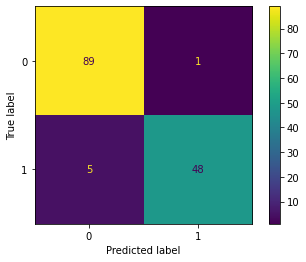

In [18]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test)

Want to make it easier to read? Add `display_labels` values.

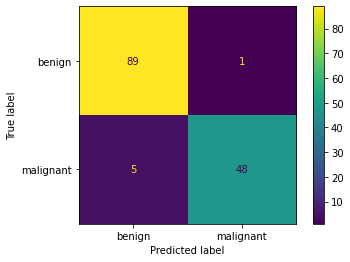

In [19]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test,
                                      display_labels=['benign', 'malignant'])

Want percentages? Pass `normalize='true'`.

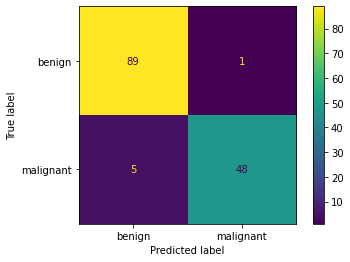

In [21]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_scaled, y_test, 
                                      display_labels=['benign', 'malignant'])

#### How many Type I errors are there?
---

<details>
    <summary>Need a hint?</summary>
    Type I = False positive
</details>

In [22]:
5

5

#### How many Type II errors are there?


In [23]:
1

1

#### Which error is worse here (Type I vs Type II)?
---

#Type II

#### Accuracy

In [24]:
knn.score(X_test_scaled, y_test)

0.958041958041958

#### Calculate the sensitivity
---

<details>
    <summary>Need a hint?</summary>
    It's the same as recall.
</details>

In [25]:
tp/(tp + fn)

0.9056603773584906

#### Calculate the specificity
---



In [26]:
tn/(tn + fp)

0.9888888888888889

#### Calculate the precision
---

<details>
    <summary>Need a hint?</summary>
    Precision starts with p, so it's the tp/ all the predicted positives.
</details>

In [27]:
tp/(tp + fp)

0.9795918367346939

## Use scikit-learn functions instead

In [28]:
from sklearn.metrics import precision_score, recall_score

In [29]:
precision_score(y_test, predictions)

0.9795918367346939

In [30]:
recall_score(y_test, predictions)

0.9056603773584906

---
## Smoking dataset
Let's look at another dataset to predict mortality from smoking status and age. Data dictionary [here](https://myweb.uiowa.edu/pbreheny/data/whickham.html).

In [31]:
df_smoke = pd.read_csv('./data/Whickham.csv')

#### Inspect

In [32]:
df_smoke.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
2,Dead,Yes,71
3,Alive,No,67
4,Alive,No,64


- `outcome`: Whether someone is alive or dead.
- `smoker`: Whether somebody smoked or did not smoke.
- `age`: Age in years.

#### Make X and y

Make `smoker` numeric. It's just two values that will definitely be in the training and test sets, so we can just binarize it (0, or 1) instead of using a scikit-learn OneHotEncoder. 

#### Create holdout/test set and training dataset

### Null model


<details><summary>In this situation, what term would we use to describe someone who is predicted to be dead but actually is alive? (Remember that alive is coded as 0 and dead is coded as 1.)</summary>

- We **falsely** predict someone to be **positive**.
- This would be a **false positive**.
</details>

<details><summary>In this situation, what is a true negative?</summary>

- We **correctly** predict someone to be **negative**.
- Someone who is predicted to be alive (`0`) and actually is alive (`0`).
</details>

## Evaluate the model performance



### Generate confusion matrix

#### Plot it!


## Basic Metrics

#### What's the accuracy?

#### What is the specificity? 

#### What is the sensitivity?

#### What is the precision?

--- 
# Exercise
## Make a better model

#### Make a LogisticRegression model with the default parameters. 


### Plot the confusion matrix

### Evaluate

### Convenient reporting

---
# More advanced metrics 🏆

## F1 score

The F1 score is the harmonic mean of precision and recall. 

If you care about precision and recall roughly the same amount, F1 score is a great metric to use! 

Note that even though all the metrics you’ve seen can be followed by the word `score` F1 almost always is. 🤷‍♀️

2 *    (Precision * Recall)      /      (Precision  + Recall)

F1 score is very popular.

## Balanced Accuracy Score

You can think of it as the average accuracy for each class.

Average of TPR and TNR

= (TP/P)+(TN/N))/2

= (Sensitivity + Specificity) / 2


### When is balanced accuracy a good metric to use?

#### Specificity = TNR

#### Balanced Accuracy

#### Accuracy Score

## ROC curve

Plot the TPR vs. FPR for the range of possible decision thresholds and you get the ROC curve!

What's the TPR?

What's the FPR?

fp = (fp + tn)

Add the handy worse-case-scenario line

TPR = Sensitivity = Recall

Note that you pass the estimator as the first argument. ⚠️

#### What happens as you move to the right along the curve?

The more area under the curve, the better separated our distributions are.
- Check out this gif - just an example ([source](https://twitter.com/DrHughHarvey/status/1104435699095404544)):

![](https://media.giphy.com/media/H1SZ5oRLIuZ1t1c4Di/giphy.gif)

We use the **area under the ROC curve** (often abbreviated **ROC AUC** or **AUC**) to quantify the gap between our distributions.

### What's the ROC AUC score?

Recall that `.predict_proba()` method will return the probabilities of both classes in a NumPy array.

#### Note that you have to pass the probabilities to `roc_auc_score`. ⚠️

## Interpreting ROC AUC
- If you have an ROC AUC of 0.5, your positive and negative populations perfectly overlap and your model is as bad as it can get.
- If you have an ROC AUC of 1, your positive and negative populations are perfectly separated and your model is as good as it can get.
- The closer your ROC AUC is to 1, the better. (1 is the maximum score.)

- If you have an ROC AUC of below 0.5, your positive and negative distributions have flipped sides. By flipping your predicted values (i.e. flipping predicted 1s and 0s), your ROC AUC will now be above 0.5.

We generate one ROC curve per model. The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize the trade-offs.

--- 
## Summary

You've seen how to create and use common classification metrics.

## Interview Questions

<details><summary>How is the ROC curve calculated?</summary>
    
The ROC curve is generated by starting our classification threshold at 0, calculating sensitivity and 1-specificity (TNR), and plotting the values. 
    
We then increment our threshold by a small number (e.g. 0.1%), and calculate and plot sensitivity and 1-specificity again. 
    
Repeat this process until we reach 1.
    
</details>

<details><summary>Let's say you were building a search engine and wanted to build a classification model that would recommend articles based on the search input. What metric would you want to optimize for and why?</summary>
    
- You could make a case for wanting to minimize false positives (stories that weren't relevant), in which case you'd want to optimize for precision.
- You could make a case for wanting to minimize false negatives (not passing along possibly useful content), in which case you'd want to optimize for recall. 
- Alumni Comment: "The interviewer seemed more interested in seeing if I knew what the metrics were and explaining what priorities would lead me to optimize for one over the other."
</details>

## Check for Understanding

You might want to make flash cards for these terms. We'll review them in the coming weeks.

- What is F1 Score?
- When would use F1 Score?
- What is balanced accuracy?
- When might you use balanced accuracy?

- What is recall?
- What is precision?
- What is sensitivity?
- What is specificity?